In [146]:
import numpy as np
import pylab as pl
import arrayfire as af
af.set_backend("cpu")
%matplotlib inline

In [147]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'  

In [148]:
# Setting velocity and spatial grid points
N_positions = 101
ghost_zones = 3
N_velocity  = 101

In [149]:
# Boundaries of domain
left_boundary  = 0
right_boundary = 1.0
length         = right_boundary - left_boundary

In [150]:
# Setting mass of the particle, boltzmann-constant
mass_particle      = 1.0
boltzmann_constant = 1.0

In [151]:
# Scattering time scale
tau   = 1.0
# Magnitude of maximum velocity
v_max = 10.0

In [152]:
# Time Parameters for the simulation:
dt         = 0.05 # Size of the time-step
final_time = 3.0
time       = np.arange(dt, final_time, dt)

In [153]:
# Setting up the temperature parameters for the simulations:
T_left   = 2.0
T_right  = 2.0
T_initial = 1.5

In [154]:
# Setting up of spatial and velocity grids:
x  = np.linspace(left_boundary, right_boundary, N_positions)
dx = x[1] - x[0]

In [155]:
# Obtaining the coordinates for the ghost-zones:
x_ghost_left  = np.linspace(-(ghost_zones)*dx + left_boundary, left_boundary - dx, ghost_zones)
x_ghost_right = np.linspace(right_boundary + dx, right_boundary + ghost_zones*dx , ghost_zones)

In [156]:
# Combining them to obtain the entire spatial grid
x  = np.concatenate([x_ghost_left, x, x_ghost_right])

In [157]:
# Obtaining the velocity grid
v  = np.linspace(-v_max, v_max, N_velocity)
x  = af.to_array(x)
v  = af.to_array(v)

In [158]:
# Conversion to allow for easy vectorization
x = af.tile(x, 1, N_velocity)
v = af.tile(af.reorder(v), N_positions + 2*ghost_zones, 1)

In [159]:
def calculate_density(f, v):
    deltav           = af.sum(v[0, 1]-v[0, 0])
    value_of_density = af.sum(f, 1)*deltav
    return(value_of_density)

In [160]:
def calculate_temperature(f, v):
    deltav               = af.sum(v[0, 1]-v[0, 0])
    value_of_temperature = af.sum(f*v**2, 1)*deltav
    return(value_of_temperature)

In [161]:
def calculate_heatflux(f, v):
    deltav               = af.sum(v[0, 1]-v[0, 0])
    value_of_heatflux    = af.sum(f*v**3, 1)*deltav
    return(value_of_heatflux)

In [162]:
def f_MB(x, v, f):
    n = af.tile(calculate_density(f, v), 1, N_velocity)
    T = af.tile(calculate_temperature(f, v), 1, N_velocity)
    f_MB = n*af.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T))*\
             af.exp(-mass_particle*v**2/(2*boltzmann_constant*T))
    return(f_MB)


In [163]:
def f_interp(dt, x, v, f):
    x_new     = x - v*dt
    step_size = af.sum(x[1,0] - x[0,0])
    f_inter   = af.constant(0, N_positions + 2*ghost_zones, N_velocity)
    f_inter[ghost_zones:-ghost_zones,:] = af.approx1(f, x_new[ghost_zones:-ghost_zones,:]/step_size, af.INTERP.CUBIC)
    
    f_inter = af.Array.as_type(f_inter, af.Dtype.f64)
    
    f_left    = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_left))*\
                af.exp(-mass_particle*v**2/(2*boltzmann_constant*T_left))
    
    f_right   = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_right))*\
                af.exp(-mass_particle*v**2/(2*boltzmann_constant*T_right))
    
    f_inter[ghost_zones:-ghost_zones,:] = af.select(x_new[ghost_zones:-ghost_zones, :]<=left_boundary, \
                                                     f_left[ghost_zones:-ghost_zones,:], \
                                                     f_inter[ghost_zones:-ghost_zones,:]
                                                    )
    
    f_inter[ghost_zones:-ghost_zones,:] = af.select(x_new[ghost_zones:-ghost_zones, :]>=right_boundary, \
                                                     f_right[ghost_zones:-ghost_zones,:], \
                                                     f_inter[ghost_zones:-ghost_zones,:]
                                                    )
    
    return f_inter


In [164]:
# Intializing the values for f
f_initial = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_initial)) * \
            af.exp(-mass_particle*v**2/(2*boltzmann_constant*T_initial))

In [165]:
f_initial[:ghost_zones,:] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_left)) * \
                            af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_left))
    
f_initial[N_positions + ghost_zones:N_positions + 2 * ghost_zones, :] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_right)) * \
                                                                        af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_right))

In [166]:
f_current = f_initial
sol2 = np.zeros(time.size)

In [167]:
for time_index, t0 in enumerate(time):
    #print("Computing For Time Index = ", time_index)
    #print("Physical Time            = ", t0)
    # We shall split the Boltzmann-Equation and solve it:
    # In this step we are solving the collisionless equation
    fstar = f_interp(dt, x, v, f_current)
    
    fstar[:ghost_zones,:] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_left)) * \
                            af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_left))
    
    fstar[N_positions + ghost_zones:N_positions + 2 * ghost_zones, :] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_right)) * \
                                                                        af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_right))

    # We turn off the term v(df/dx) for the following two steps
#     f0             = f_MB(x, v, fstar)
#     f_new          = f0 + (fstar - f0)*np.exp(-dt/tau)
    
#     f_new[:ghost_zones,:] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_left)) * \
#                             af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_left))
    
#     f_new[N_positions + ghost_zones:N_positions + 2 * ghost_zones, :] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_right)) * \
#                                                                         af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_right))


    #f_current = f_new
    f_current = fstar
    temp      = calculate_temperature(f_current[ghost_zones:-ghost_zones, :], v[ghost_zones:-ghost_zones, :])
    sol2[time_index] = af.sum(temp)/af.Array.elements(temp)

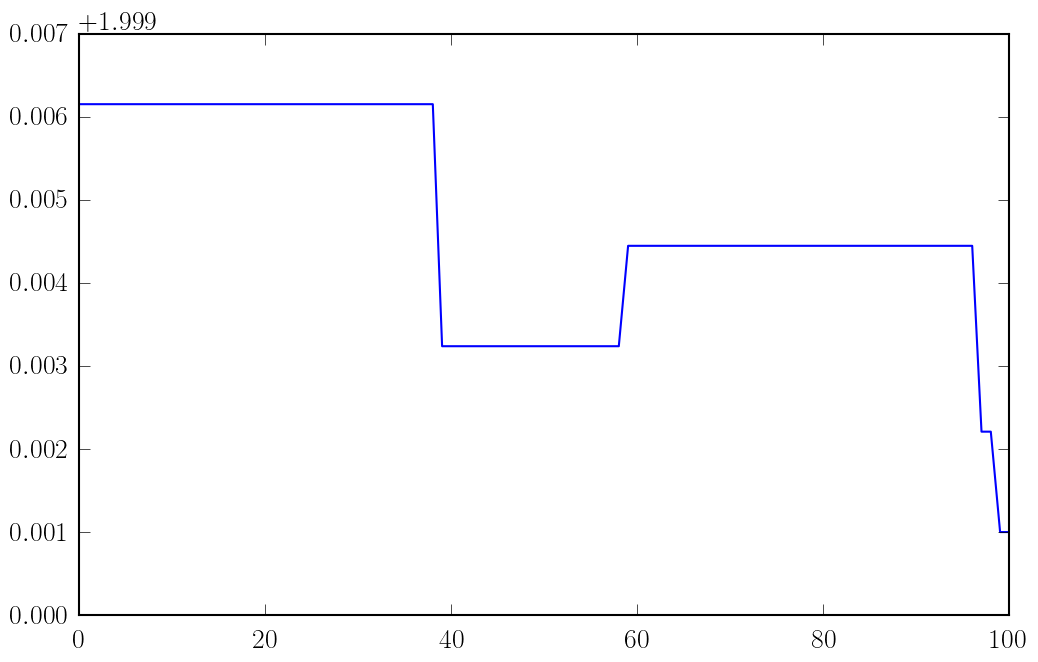

In [171]:
import h5py
h5f = h5py.File('analytical.h5', 'r')
sol = h5f['soln'][:]
time2 = h5f['time'][:]
h5f.close()
new=np.zeros(time2.size)
for i in range(1,31):
    new+=sol[i][:]
new=new/30
pl.plot(temp)

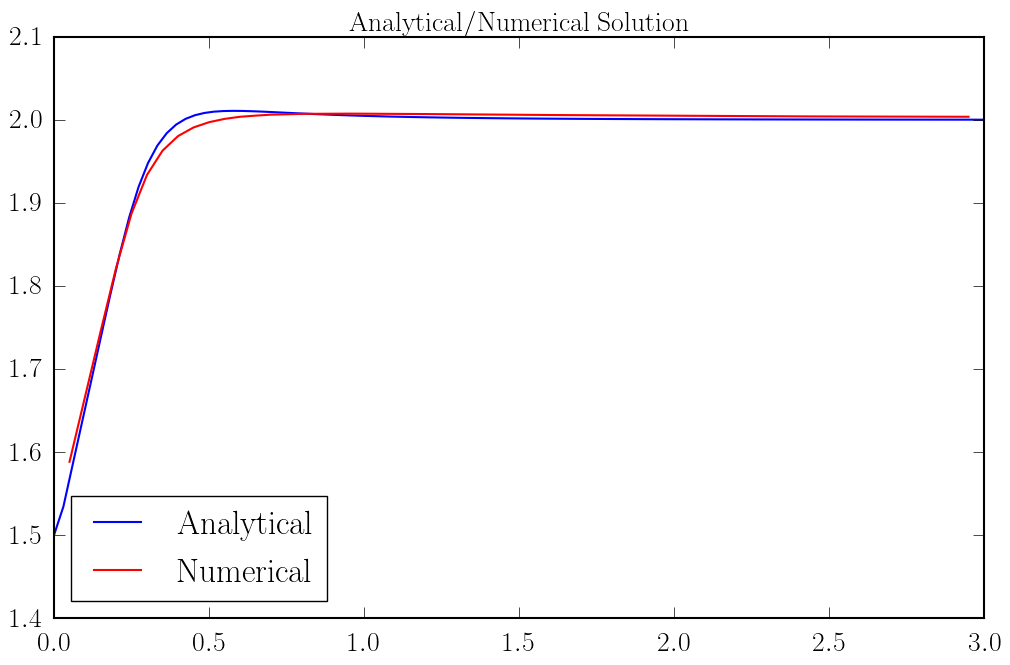

In [169]:
pl.plot(time2, np.abs(new),'b', label='$\mathrm{Analytical}$')
pl.plot(time, np.abs(sol2),'r', label='$\mathrm{Numerical}$')
pl.title('$\mathrm{Analytical/Numerical}$ $\mathrm{Solution}$')
pl.legend(loc = 'best')

In [44]:
af.max(f_current)

50128516.0